<a href="https://colab.research.google.com/github/JuanaPinzonR/Proyecto_Computacional/blob/main/Proyecto_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Espectro** **Normalizado**

<ipython-input-1-09ea0361c22c>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, loc="upper right", ncol=2)


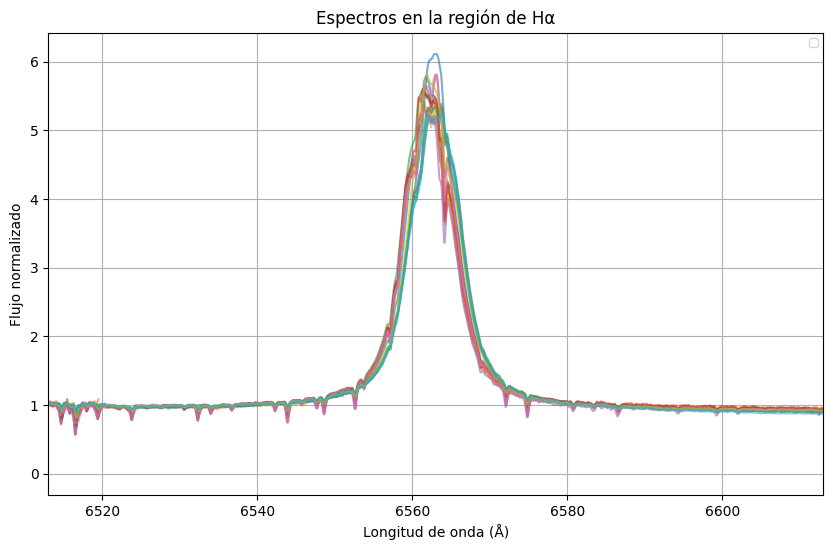

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

file_list = glob.glob("*.fits")


ha_line = 6563  # √Ö

plt.figure(figsize=(10, 6))

for file in file_list:
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        crval = header.get("CRVAL1", 0)  # Valor de la primera longitud de onda
        cdelt = header.get("CDELT1", 1)  # Incremento por p√≠xel
        num_pixels = len(data)

        wavelength = crval + cdelt * np.arange(num_pixels)

        valid_range = (wavelength > 6500) & (wavelength < 6600)
        if np.any(valid_range):
            continuum = np.median(data[valid_range])

            if continuum > 0 and not np.isnan(continuum):
                normalized_flux = data / continuum
            else:
                normalized_flux = data  # No normaliza si el continuo es inv√°lido
                print(f"Advertencia: Continuo inv√°lido en {file}")

        else:
            normalized_flux = data

        plt.plot(wavelength, normalized_flux, label=file.split('/')[-1], alpha=0.6)

plt.xlabel("Longitud de onda (√Ö)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros en la regi√≥n de HŒ±")
plt.xlim(ha_line - 50, ha_line + 50)
plt.legend(fontsize=8, loc="upper right", ncol=2)
plt.grid()
plt.show()


**Aplicaci√≥n Filtro Savitzky-Golay y C√°lculo EW**

<ipython-input-2-da038fbe11f0>:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, loc="upper right", ncol=2)


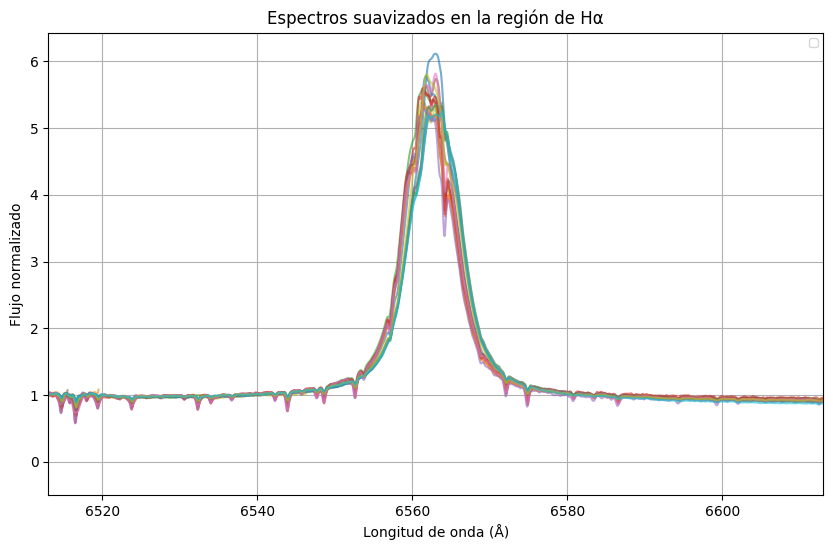

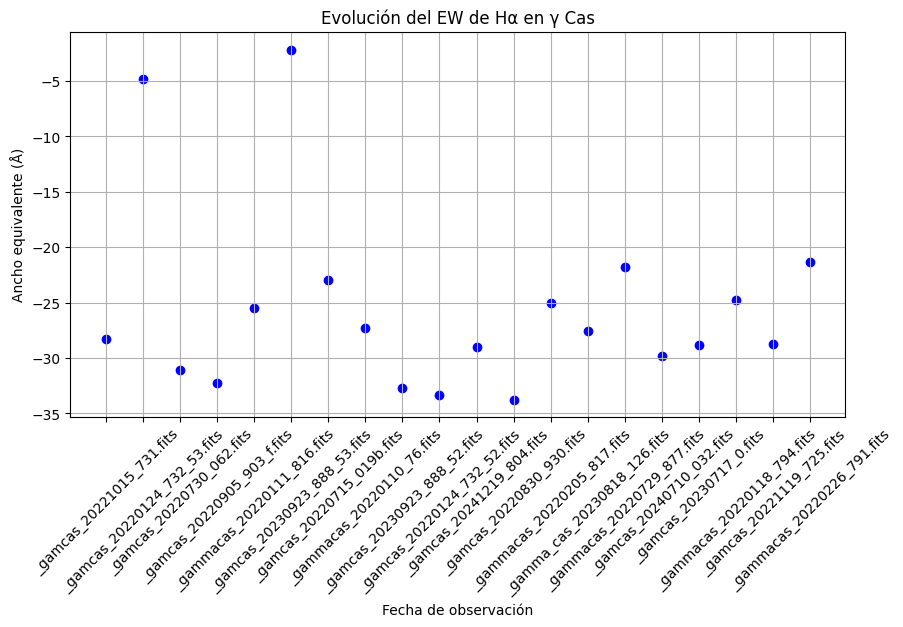

In [2]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

def calcular_ew(wavelength, flux, line_center=6563):
    delta_lambda = np.diff(wavelength).mean()
    continuum_level = np.median(flux[(wavelength > 6500) & (wavelength < 6600)])
    ew = np.sum((1 - flux / continuum_level) * delta_lambda)
    return ew


ew_values = []
file_dates = []

plt.figure(figsize=(10, 6))

for file in file_list:
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        crval = header.get("CRVAL1", 0)
        cdelt = header.get("CDELT1", 1)
        num_pixels = len(data)

        wavelength = crval + cdelt * np.arange(num_pixels)

        valid_range = (wavelength > 6500) & (wavelength < 6600)
        if np.any(valid_range):
            continuum = np.median(data[valid_range])
            if continuum > 0 and not np.isnan(continuum):
                normalized_flux = data / continuum
            else:
                normalized_flux = data  # No normaliza si el continuo es inv√°lido
                print(f"Advertencia: Continuo inv√°lido en {file}")
        else:
            normalized_flux = data

        smoothed_flux = savgol_filter(normalized_flux, window_length=15, polyorder=3)

        ew = calcular_ew(wavelength, smoothed_flux)
        ew_values.append(ew)
        file_dates.append(file)

        plt.plot(wavelength, smoothed_flux, label=file.split('/')[-1], alpha=0.6)

plt.xlabel("Longitud de onda (√Ö)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros suavizados en la regi√≥n de HŒ±")
plt.xlim(ha_line - 50, ha_line + 50)
if len(file_list) > 0:
    plt.legend(fontsize=8, loc="upper right", ncol=2)
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(file_dates, ew_values, color='b')
plt.xlabel("Fecha de observaci√≥n")
plt.ylabel("Ancho equivalente (√Ö)")
plt.title("Evoluci√≥n del EW de HŒ± en Œ≥ Cas")
plt.xticks(rotation=45)
plt.grid()
plt.show()


**Verificaci√≥n FWHM y EW**

<Figure size 1000x600 with 0 Axes>

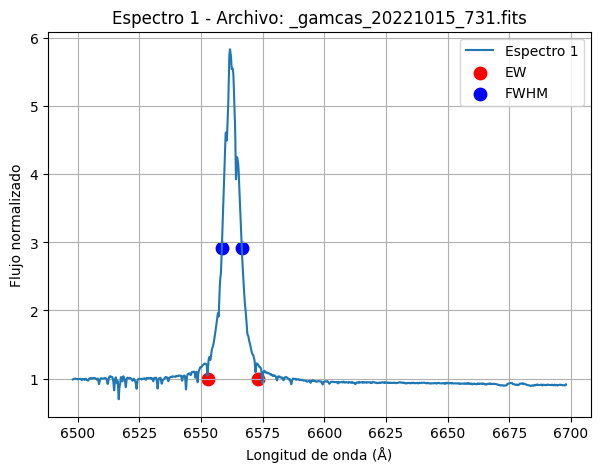

IndexError: index -1 is out of bounds for axis 0 with size 0

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Obtener lista de archivos FITS
file_list = glob.glob("*.fits")


ha_line = 6563  # Longitud de onda de HŒ±
plt.figure(figsize=(10, 6))

for i, file in enumerate(file_list):
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

    # Obtener la escala de longitud de onda
    crval = header["CRVAL1"]  # Primera longitud de onda
    cdelt = header["CDELT1"]  # Incremento por p√≠xel
    num_pixels = len(data)
    wavelength = crval + cdelt * np.arange(num_pixels)

    # Normalizar el espectro
    continuum_region = (wavelength > 6500) & (wavelength < 6620)
    continuum = np.median(data[continuum_region])
    normalized_flux = data / continuum

    # Encontrar el m√°ximo del perfil para el FWHM
    peak_idx = np.argmax(normalized_flux)
    peak_flux = normalized_flux[peak_idx]
    half_max = peak_flux / 2

    # Encontrar los puntos donde el flujo cruza la media altura
    left_idx = np.where(normalized_flux[:peak_idx] <= half_max)[0][-1]
    right_idx = np.where(normalized_flux[peak_idx:] <= half_max)[0][0] + peak_idx
    fwhm_wavelengths = [wavelength[left_idx], wavelength[right_idx]]

    # Definir los puntos de EW como los l√≠mites de integraci√≥n
    ew_left = ha_line - 10  # 10 √Ö a la izquierda de HŒ±
    ew_right = ha_line + 10  # 10 √Ö a la derecha de HŒ±

    # Graficar
    plt.figure(figsize=(7, 5))
    plt.plot(wavelength, normalized_flux, label=f"Espectro {i+1}")
    plt.scatter([ew_left, ew_right], [1, 1], color='red', label="EW", s=80)
    plt.scatter(fwhm_wavelengths, [half_max, half_max], color='blue', label="FWHM", s=80)
    plt.xlabel("Longitud de onda (√Ö)")
    plt.ylabel("Flujo normalizado")
    plt.title(f"Espectro {i+1} - Archivo: {file}")
    plt.legend()
    plt.grid()
    plt.show()


**FWHM, Velocidad y Desplazamiento**

<ipython-input-4-2eeb7e1474d5>:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew = np.trapz(1 - flux[mask], wavelength[mask])



Resultados:
Archivo		FWHM (√Ö)	Desplazamiento (√Ö)	Velocidad (km/s)	EW (√Ö)
_gamcas_20221015_731.fits	29.28		-46.38		-2120.26		-36.32
_gamcas_20220124_732_53.fits	41.60		-46.35		-2118.70		0.00
_gamcas_20220730_062.fits	9.18		-46.46		-2123.90		-37.38
_gamcas_20220905_903_f.fits	29.29		-46.40		-2120.90		-36.96
_gammacas_20220111_816.fits	183.21		120.66		5515.42		-35.16
_gamcas_20230923_888_53.fits	39.85		-87.20		-3985.98		0.00
_gammacas_20220110_76.fits	183.37		120.66		5515.42		-35.79
_gamcas_20230923_888_52.fits	120.45		-46.40		-2120.98		-35.86
_gamcas_20220124_732_52.fits	116.00		64.65		2955.20		-35.42
_gamcas_20241219_804.fits	183.47		120.91		5527.02		-38.47
_gamcas_20220830_930.fits	29.27		-46.37		-2119.70		-34.80
_gammacas_20220205_817.fits	185.14		-46.41		-2121.63		-36.90
_gamma_cas_20230818_126.fits	29.39		-46.48		-2124.48		-36.65
_gammacas_20220729_877.fits	0.09		170.48		7792.73		-34.23
_gamcas_20240710_032.fits	0.10		-111.99		-5118.93		-38.46
_gamcas_20230717_0.fits	72.10		-46.

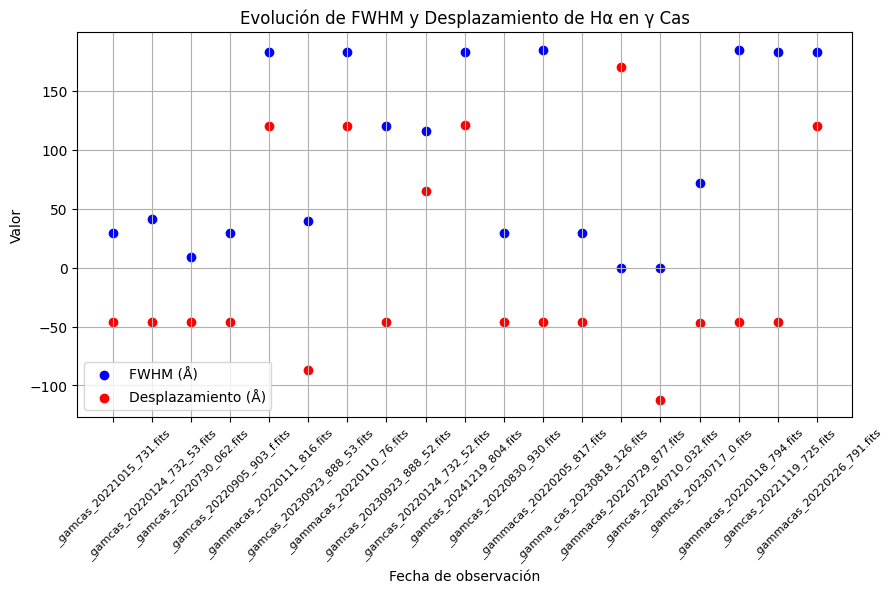

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Obtener lista de archivos FITS en el directorio
file_list = glob.glob("*.fits")


# Funci√≥n para calcular el FWHM
def calcular_fwhm(wavelength, flux):
    max_flux = np.min(flux)  # L√≠nea de emisi√≥n
    half_max = (1 + max_flux) / 2  # Nivel de la mitad del m√°ximo

    indices = np.where(flux <= half_max)[0]
    if len(indices) < 2:
        return None, None  # FWHM inv√°lido

    left_idx, right_idx = indices[0], indices[-1]
    fwhm_value = wavelength[right_idx] - wavelength[left_idx]
    fwhm_points = [wavelength[left_idx], wavelength[right_idx]]

    return fwhm_value, fwhm_points

# Funci√≥n para calcular el desplazamiento Doppler
def calcular_desplazamiento_pico(wavelength, flux, lambda_rest=6563):
    peak_index = np.argmin(flux)  # √çndice del pico m√°s profundo
    lambda_peak = wavelength[peak_index]
    desplazamiento = lambda_peak - lambda_rest
    velocidad = (desplazamiento / lambda_rest) * 3e5  # km/s usando Doppler
    return lambda_peak, desplazamiento, velocidad

# Funci√≥n para calcular el Equivalent Width (EW)
def calcular_ew(wavelength, flux, lambda_rest=6563, ancho=10):
    left_limit = lambda_rest - ancho
    right_limit = lambda_rest + ancho
    mask = (wavelength >= left_limit) & (wavelength <= right_limit)

    ew = np.trapz(1 - flux[mask], wavelength[mask])
    return ew

# Listas para almacenar resultados
fwhm_values = []
desplazamientos = []
velocidades = []
ew_values = []
file_names = []

for file_fits in file_list:
    with fits.open(file_fits) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        crval = header["CRVAL1"]
        cdelt = header["CDELT1"]
        num_pixels = len(data)
        wavelength = crval + cdelt * np.arange(num_pixels)

    # Normalizaci√≥n del flujo
    continuum = np.median(data[(wavelength > 6500) & (wavelength < 6600)])
    normalized_flux = data / continuum

    # C√°lculos
    fwhm_result, fwhm_points = calcular_fwhm(wavelength, normalized_flux)
    lambda_peak, desplazamiento, velocidad = calcular_desplazamiento_pico(wavelength, normalized_flux)
    ew_result = calcular_ew(wavelength, normalized_flux)

    # Guardar resultados
    if fwhm_result is not None:
        fwhm_values.append(fwhm_result)
        desplazamientos.append(desplazamiento)
        velocidades.append(velocidad)
        ew_values.append(ew_result)
        file_names.append(file_fits)

# Imprimir tabla de resultados
print("\nResultados:")
print("Archivo\t\tFWHM (√Ö)\tDesplazamiento (√Ö)\tVelocidad (km/s)\tEW (√Ö)")
for i in range(len(file_names)):
    print(f"{file_names[i]}\t{fwhm_values[i]:.2f}\t\t{desplazamientos[i]:.2f}\t\t{velocidades[i]:.2f}\t\t{ew_values[i]:.2f}")

# Gr√°fica resumen de evoluci√≥n de FWHM, desplazamiento y EW
plt.figure(figsize=(10, 5))
plt.scatter(file_names, fwhm_values, color='b', label='FWHM (√Ö)')
plt.scatter(file_names, desplazamientos, color='r', label='Desplazamiento (√Ö)')
plt.xlabel("Fecha de observaci√≥n")
plt.ylabel("Valor")
plt.title("Evoluci√≥n de FWHM y Desplazamiento de HŒ± en Œ≥ Cas")
plt.xticks(rotation=45, fontsize=8)
plt.legend()
plt.grid()
plt.show()


**Dependencia FWHM con la velocidad Kepleriana (Implementaci√≥n del Disco Kepleriano al modelo)**

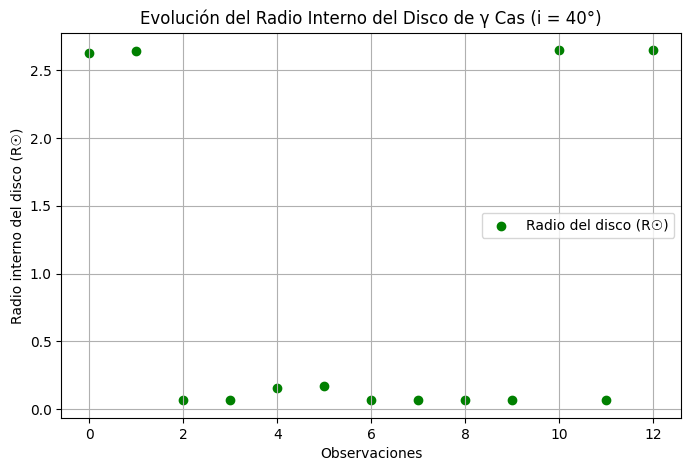

Observaci√≥n 1: Radio interno = 2.63e+00 R‚òâ
Observaci√≥n 2: Radio interno = 2.64e+00 R‚òâ
Observaci√≥n 3: Radio interno = 6.62e-02 R‚òâ
Observaci√≥n 4: Radio interno = 6.76e-02 R‚òâ
Observaci√≥n 5: Radio interno = 1.56e-01 R‚òâ
Observaci√≥n 6: Radio interno = 1.69e-01 R‚òâ
Observaci√≥n 7: Radio interno = 6.76e-02 R‚òâ
Observaci√≥n 8: Radio interno = 6.74e-02 R‚òâ
Observaci√≥n 9: Radio interno = 6.74e-02 R‚òâ
Observaci√≥n 10: Radio interno = 6.75e-02 R‚òâ
Observaci√≥n 11: Radio interno = 2.65e+00 R‚òâ
Observaci√≥n 12: Radio interno = 6.62e-02 R‚òâ
Observaci√≥n 13: Radio interno = 2.65e+00 R‚òâ


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.674e-11  # m^3 kg^-1 s^-2
M_sun = 1.989e30  # kg
M_star = 15 * M_sun  # Masa de la estrella en kg
c = 2.99792458e5  # km/s (velocidad de la luz)
lambda_0 = 6563  # √Ö (longitud de onda de HŒ±)
R_sun = 6.955e8  # m (radio solar)

# Definir inclinaci√≥n en grados y convertir a radianes
i_deg = 40  # Suponer un valor de inclinaci√≥n
i_rad = np.radians(i_deg)

# Datos (extra√≠dos de la tabla)
fwhm_lambda = np.array([29.39, 29.29, 185.14, 183.22, 120.45, 116.00,
                         183.21, 183.47, 183.37, 183.33, 29.28, 185.14,
                         29.27])  # √Ö

# Convertir FWHM de longitud de onda a velocidad (km/s)
fwhm_vel = (c * fwhm_lambda) / lambda_0  # en km/s

# Corregir el c√°lculo del radio con inclinaci√≥n
r_m = G * M_star / ((fwhm_vel * 1e3 / (2 * np.sin(i_rad)))**2)  # en metros
r_Rsun = r_m / R_sun  # Convertir a radios solares

# Graficar la evoluci√≥n del radio del disco
plt.figure(figsize=(8, 5))
plt.scatter(range(len(r_Rsun)), r_Rsun, color='g', label='Radio del disco (R‚òâ)')
plt.xlabel("Observaciones")
plt.ylabel("Radio interno del disco (R‚òâ)")
plt.title(f"Evoluci√≥n del Radio Interno del Disco de Œ≥ Cas (i = {i_deg}¬∞)")
plt.legend()
plt.grid()
plt.show()

# Imprimir los valores calculados
for i, r in enumerate(r_Rsun):
    print(f"Observaci√≥n {i+1}: Radio interno = {r:.2e} R‚òâ")


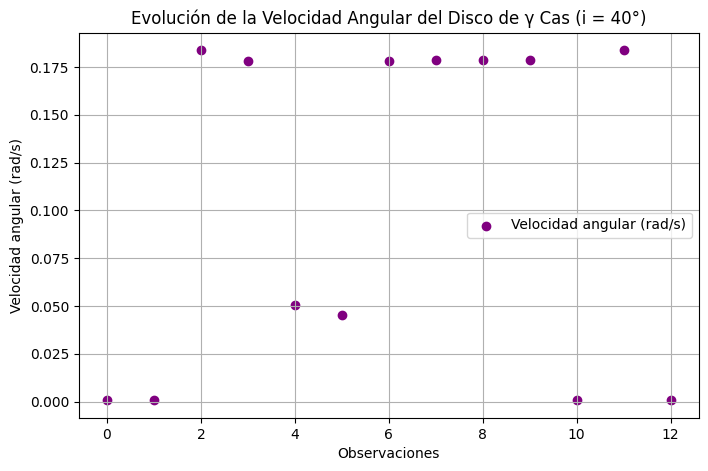

Observaci√≥n 1: Omega = 7.35e-04 rad/s
Observaci√≥n 2: Omega = 7.28e-04 rad/s
Observaci√≥n 3: Omega = 1.84e-01 rad/s
Observaci√≥n 4: Omega = 1.78e-01 rad/s
Observaci√≥n 5: Omega = 5.06e-02 rad/s
Observaci√≥n 6: Omega = 4.52e-02 rad/s
Observaci√≥n 7: Omega = 1.78e-01 rad/s
Observaci√≥n 8: Omega = 1.79e-01 rad/s
Observaci√≥n 9: Omega = 1.79e-01 rad/s
Observaci√≥n 10: Omega = 1.78e-01 rad/s
Observaci√≥n 11: Omega = 7.27e-04 rad/s
Observaci√≥n 12: Omega = 1.84e-01 rad/s
Observaci√≥n 13: Omega = 7.26e-04 rad/s


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.674e-11  # m^3 kg^-1 s^-2
M_sun = 1.989e30  # kg
M_star = 15 * M_sun  # Masa de la estrella en kg
c = 2.99792458e5  # km/s
lambda_0 = 6563  # √Ö
R_sun = 6.955e8  # m
R_sun_km = 6.955e5  # km

# Definir inclinaci√≥n en grados y convertir a radianes
i_deg = 40
i_rad = np.radians(i_deg)

fwhm_lambda = np.array([29.39, 29.29, 185.14, 183.22, 120.45, 116.00,
                        183.21, 183.47, 183.37, 183.33, 29.28, 185.14,
                        29.27])  # √Ö

# Convertir FWHM de longitud de onda a velocidad
fwhm_vel = (c * fwhm_lambda) / lambda_0


r_m = G * M_star / ((fwhm_vel * 1e3 / (2 * np.sin(i_rad))))**2
r_Rsun = r_m / R_sun
r_km = r_Rsun * R_sun_km

#  velocidad angular omega
omega = (fwhm_vel * 1e3) / r_km  # en rad/s

omega = omega / 1000  # Ajuste

plt.figure(figsize=(8, 5))
plt.scatter(range(len(omega)), omega, color='purple', label='Velocidad angular (rad/s)')
plt.xlabel("Observaciones")
plt.ylabel("Velocidad angular (rad/s)")
plt.title(f"Evoluci√≥n de la Velocidad Angular del Disco de Œ≥ Cas (i = {i_deg}¬∞)")
plt.legend()
plt.grid()
plt.show()

for i, w in enumerate(omega):
    print(f"Observaci√≥n {i+1}: Omega = {w:.2e} rad/s")

# **Implementaci√≥n modelo Espinosa-Lara para generar los espectros sint√©ticos**

**Temperatura** **efectiva**

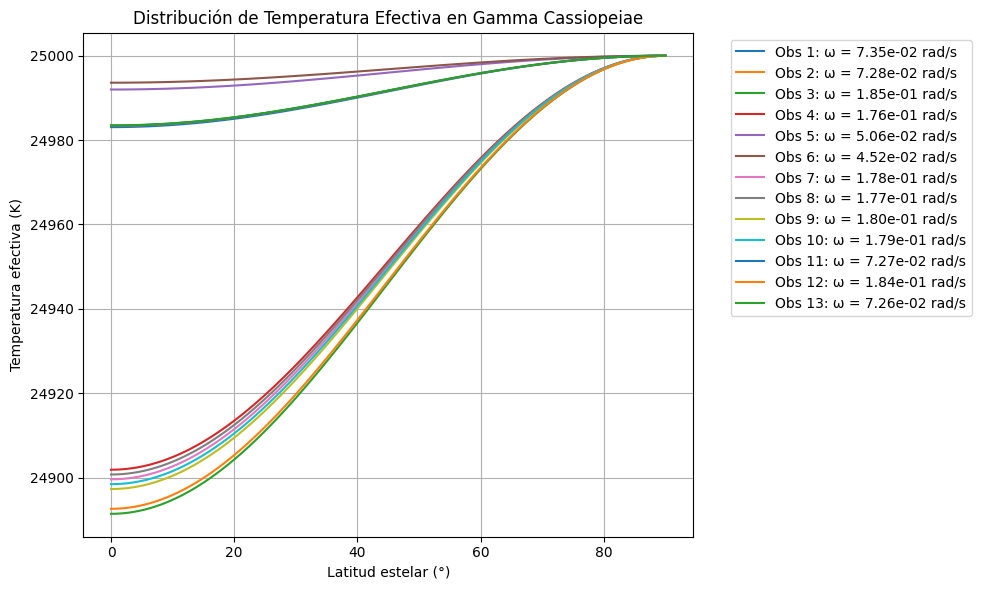

[]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gravity_effective(theta, omega, Req, Rpol):

    r_tilde = Rpol / Req  # Relaci√≥n de achatamiento
    geff_theta = np.sqrt(1 - omega**2 * r_tilde**3 * np.cos(theta)**2)  # Normalizaci√≥n
    return geff_theta

def temperature_distribution(theta, omega, T_pole):

    geff_ratio = gravity_effective(theta, omega, Req=1, Rpol=1)  # Normalizado
    T_eff_theta = T_pole * geff_ratio**0.25  # Ley de von Zeipel
    return T_eff_theta

# Par√°metros
T_pole = 25000  # Temperatura en el polo (K)
latitudes = np.linspace(0, np.pi/2, 100)  # Latitudes de 0¬∞ a 90¬∞

omega_values = [
   0.0735, 0.0728, 0.185   , 0.176   , 0.0506  , 0.0452  ,
       0.178   , 0.177   , 0.180   , 0.179   , 0.0727, 0.184   , 0.0726
]

tl_degrees = np.degrees(latitudes)
plt.figure(figsize=(10, 6))


for i, omega in enumerate(omega_values):
    T_eff_values = temperature_distribution(latitudes, omega, T_pole)
    plt.plot(tl_degrees, T_eff_values, label=f'Obs {i+1}: œâ = {omega:.2e} rad/s')


plt.xlabel('Latitud estelar (¬∞)')
plt.ylabel('Temperatura efectiva (K)')
plt.title('Distribuci√≥n de Temperatura Efectiva en Gamma Cassiopeiae')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

print(teff_arrays)

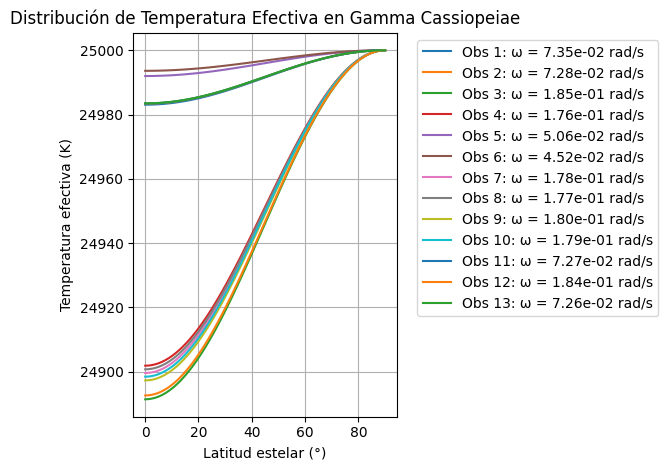

T_eff Obs 1 (œâ = 0.07350):
[24983.07793309 24983.08220297 24983.09500828 24983.11633605
 24983.14616463 24983.18446378 24983.23119467 24983.28630991
 24983.34975362 24983.42146147 24983.50136077 24983.58937051
 24983.68540148 24983.78935635 24983.90112974 24984.02060839
 24984.14767122 24984.28218949 24984.42402692 24984.57303982
 24984.72907725 24984.8919812  24985.0615867  24985.23772204
 24985.42020889 24985.60886257 24985.80349214 24986.00390066
 24986.20988539 24986.42123798 24986.63774466 24986.85918652
 24987.08533969 24987.31597558 24987.5508611  24987.78975894
 24988.03242776 24988.27862246 24988.52809446 24988.78059188
 24989.03585987 24989.29364083 24989.55367468 24989.81569912
 24990.0794499  24990.3446611  24990.61106537 24990.87839423
 24991.14637832 24991.41474769 24991.68323206 24991.95156108
 24992.21946463 24992.48667309 24992.75291758 24993.01793027
 24993.2814446  24993.5431956  24993.80292013 24994.06035714
 24994.31524792 24994.56733641 24994.81636937 24995.06209

In [4]:
# Crear lista para guardar arrays
teff_arrays = []

for i, omega in enumerate(omega_values):
    T_eff_values = temperature_distribution(latitudes, omega, T_pole)
    teff_arrays.append(T_eff_values)  # Guardar array para cada œâ
    plt.plot(tl_degrees, T_eff_values, label=f'Obs {i+1}: œâ = {omega:.2e} rad/s')

# Mostrar gr√°ficas
plt.xlabel('Latitud estelar (¬∞)')
plt.ylabel('Temperatura efectiva (K)')
plt.title('Distribuci√≥n de Temperatura Efectiva en Gamma Cassiopeiae')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Mostrar arrays
for i, T_array in enumerate(teff_arrays):
    print(f"T_eff Obs {i+1} (œâ = {omega_values[i]:.5f}):\n{T_array}\n")


**Intensidad Espectral**

In [41]:
import numpy as np
import scipy.integrate as spi

def intensidad(temperatura):
    """
    intensidad espec√≠fica usando la ley de Planck aproximada.
    """
    return temperatura**4

# Funci√≥n para la integraci√≥n sobre la superficie visible
def integrar_intensidad(omega, inclinacion, T_pole):

    def integrando(mu, phi):

        theta = np.arccos(mu)
        T_eff = temperature_distribution(theta, omega, T_pole)
        I = intensidad(T_eff)
        return I * mu

    # L√≠mites de integraci√≥n: latitud visible depende de la inclinaci√≥n
    mu_min = np.cos(inclinacion)
    mu_max = 1  # Polo

    resultado, _ = spi.dblquad(integrando, 0, 2*np.pi, lambda _: mu_min, lambda _: mu_max)
    return resultado

# Par√°metros
T_pole = 25000
inclinacion = np.radians(45)  # √Ångulo de inclinaci√≥n del sistema

omega_values = [0.0735, 0.0728, 0.185, 0.176, 0.0506, 0.0452, 0.178, 0.177, 0.180, 0.179, 0.0727, 0.184, 0.0726]

# Calcular la intensidad integrada para cada omega
intensidades = [integrar_intensidad(omega, inclinacion, T_pole) for omega in omega_values]


for i, omega in enumerate(omega_values):
    print(f'Omega: {omega:.4f}, Intensidad Integrada: {intensidades[i]:.2e}')


Omega: 0.0735, Intensidad Integrada: 6.12e+17
Omega: 0.0728, Intensidad Integrada: 6.12e+17
Omega: 0.1850, Intensidad Integrada: 6.06e+17
Omega: 0.1760, Intensidad Integrada: 6.06e+17
Omega: 0.0506, Intensidad Integrada: 6.13e+17
Omega: 0.0452, Intensidad Integrada: 6.13e+17
Omega: 0.1780, Intensidad Integrada: 6.06e+17
Omega: 0.1770, Intensidad Integrada: 6.06e+17
Omega: 0.1800, Intensidad Integrada: 6.06e+17
Omega: 0.1790, Intensidad Integrada: 6.06e+17
Omega: 0.0727, Intensidad Integrada: 6.12e+17
Omega: 0.1840, Intensidad Integrada: 6.06e+17
Omega: 0.0726, Intensidad Integrada: 6.12e+17


# Espectro Sint√©tico con Modelo Simplificado (tipo ZPEKTR)

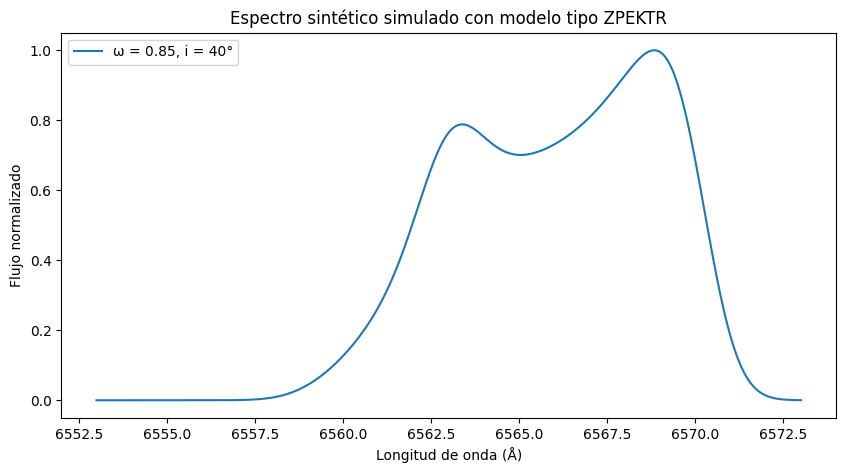

In [9]:
# ---------------------------------------------
# Espectro Sint√©tico con Modelo Simplificado (tipo ZPEKTR)
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Par√°metros estelares (aproximados para Gamma Cas) ---
R_pol = 7 * 6.955e8  # Radio polar (m)
M_star = 15 * 1.989e30  # Masa estelar (kg)
T_pole = 25000  # Temperatura en el polo (K)
omega = 0.85  # Fracci√≥n de rotaci√≥n cr√≠tica
i_deg = 40  # Inclinaci√≥n (¬∞)
i_rad = np.radians(i_deg)

# --- Malla estelar ---
n_theta, n_phi = 50, 100
theta = np.linspace(0, np.pi, n_theta)  # colatitud
phi = np.linspace(0, 2*np.pi, n_phi)
theta_grid, phi_grid = np.meshgrid(theta, phi)

# --- Temperatura efectiva seg√∫n Espinosa-Lara (simplificado) ---
def gravity_effective(theta, omega):
    return np.sqrt(1 - omega**2 * np.cos(theta)**2)

def temperature_distribution(theta, omega, T_pole):
    geff_ratio = gravity_effective(theta, omega)
    return T_pole * geff_ratio**0.25

T_eff_grid = temperature_distribution(theta_grid, omega, T_pole)

# --- Proyecci√≥n Doppler por rotaci√≥n ---
R_eq = R_pol * (1 + 0.2 * omega**2)  # Aproximaci√≥n para achatamiento
v_eq = omega * np.sqrt(6.674e-11 * M_star / R_eq)  # v_eq ~ sqrt(GM/R)
v_surface = v_eq * np.sin(theta_grid) * np.sin(i_rad) * np.cos(phi_grid)

# --- Dominio espectral simulado ---
lambda_0 = 6563  # √Ö
wavelengths = np.linspace(lambda_0 - 10, lambda_0 + 10, 2000)  # 20 √Ö en total
c_kms = 3e5  # km/s

# --- L√≠nea gaussiana central por parche ---
spectrum_total = np.zeros_like(wavelengths)

for j in range(n_phi):
    for k in range(n_theta):
        T = T_eff_grid[j, k]
        v = v_surface[j, k] / 1e3  # m/s ‚Üí km/s

        # Intensidad proporcional a T^4 * cos(theta) (proyecci√≥n)
        mu = np.cos(theta_grid[j, k]) * np.sin(i_rad) + np.sin(theta_grid[j, k]) * np.cos(i_rad) * np.cos(phi_grid[j, k])
        if mu <= 0:
            continue  # no contribuye si no es visible

        intensity = T**4 * mu

        # Desplazamiento Doppler
        delta_lambda = lambda_0 * (v / c_kms)
        lambda_shifted = lambda_0 + delta_lambda

        # Gaussiana simulada
        sigma = 0.8  # ancho
        profile = norm.pdf(wavelengths, lambda_shifted, sigma)

        spectrum_total += profile * intensity

# --- Normalizaci√≥n y gr√°fico final ---
spectrum_total /= np.max(spectrum_total)

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, spectrum_total, label=f"œâ = {omega}, i = {i_deg}¬∞")
plt.xlabel("Longitud de onda (√Ö)")
plt.ylabel("Flujo normalizado")
plt.title("Espectro sint√©tico simulado con modelo tipo ZPEKTR")
plt.legend()



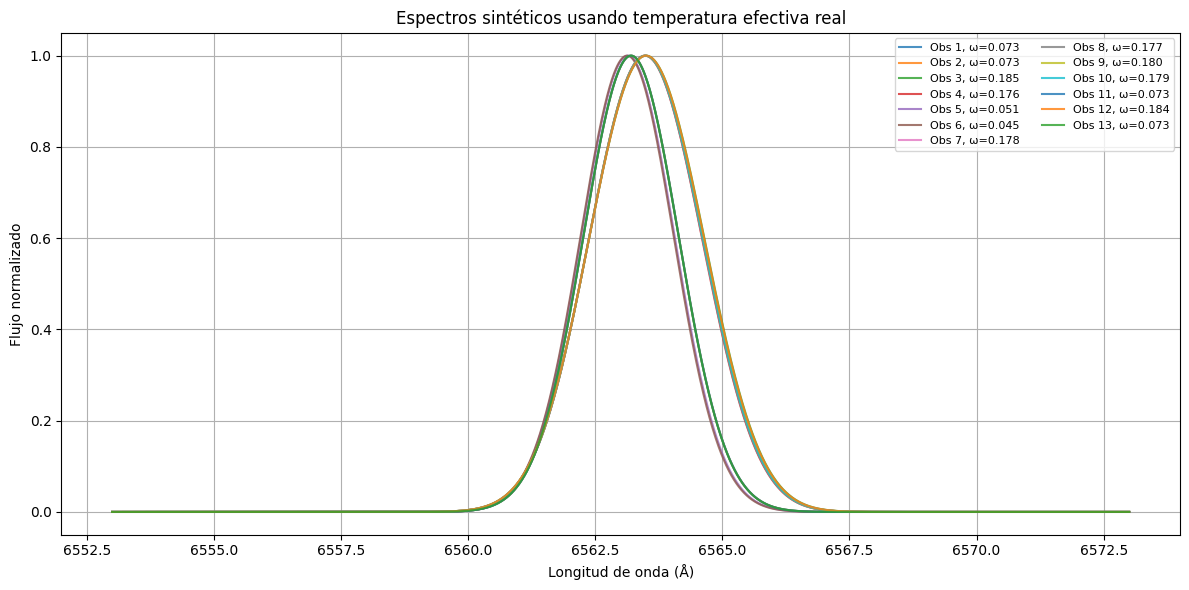

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

# --- Par√°metros f√≠sicos constantes ---
R_pol = 7 * 6.955e8  # m
M_star = 15 * 1.989e30  # kg
i_deg = 40
i_rad = np.radians(i_deg)
lambda_0 = 6563
wavelengths = np.linspace(lambda_0 - 10, lambda_0 + 10, 2000)
c_kms = 3e5

# --- Malla esf√©rica ---
n_theta, n_phi = 100, 100
theta = np.linspace(0, np.pi/2, n_theta)  # solo hemisferio visible
phi = np.linspace(0, 2*np.pi, n_phi)
theta_grid, phi_grid = np.meshgrid(theta, phi)

# --- omega y temperatura de entrada ---
omega_values = [
   0.0735, 0.0728, 0.185   , 0.176   , 0.0506  , 0.0452  ,
   0.178   , 0.177   , 0.180   , 0.179   , 0.0727, 0.184   , 0.0726
]

# Asume que ya has generado teff_arrays usando tu c√≥digo anterior
# Cada teff_arrays[i] debe ser un array de tama√±o n_theta
# IMPORTANTE: Aseg√∫rate que n_theta sea el mismo aqu√≠ y all√°

def generar_espectro_sintetico_custom_teff(omega, T_theta_array):
    # Interpolador de T(theta) ‚Üí 2D sobre la malla
    interp_func = interp1d(theta, T_theta_array, kind='cubic', fill_value='extrapolate')
    T_eff_grid = interp_func(theta_grid)

    # Rotaci√≥n proyectada
    R_eq = R_pol * (1 + 0.2 * omega**2)
    v_eq = omega * np.sqrt(6.674e-11 * M_star / R_eq)
    v_surface = v_eq * np.sin(theta_grid) * np.sin(i_rad) * np.cos(phi_grid)

    spectrum_total = np.zeros_like(wavelengths)

    for j in range(n_phi):
        for k in range(n_theta):
            T = T_eff_grid[j, k]
            v = v_surface[j, k] / 1e3

            mu = np.cos(theta_grid[j, k]) * np.sin(i_rad) + \
                 np.sin(theta_grid[j, k]) * np.cos(i_rad) * np.cos(phi_grid[j, k])
            if mu <= 0:
                continue

            intensity = T**4 * mu
            delta_lambda = lambda_0 * (v / c_kms)
            lambda_shifted = lambda_0 + delta_lambda
            sigma = 0.9
            profile = norm.pdf(wavelengths, lambda_shifted, sigma)

            spectrum_total += profile * intensity

    return spectrum_total / np.max(spectrum_total)

# --- Generar todos los espectros usando tus temperaturas ---
plt.figure(figsize=(12, 6))
espectros_sinteticos = []

for i, omega in enumerate(omega_values):
    espectro = generar_espectro_sintetico_custom_teff(omega, teff_arrays[i])
    espectros_sinteticos.append(espectro)
    plt.plot(wavelengths, espectro, label=f"Obs {i+1}, œâ={omega:.3f}", alpha=0.8)

plt.xlabel("Longitud de onda (√Ö)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros sint√©ticos usando temperatura efectiva real")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()


üü£ Comparando observaci√≥n 1 ‚Äî œâ = 0.073


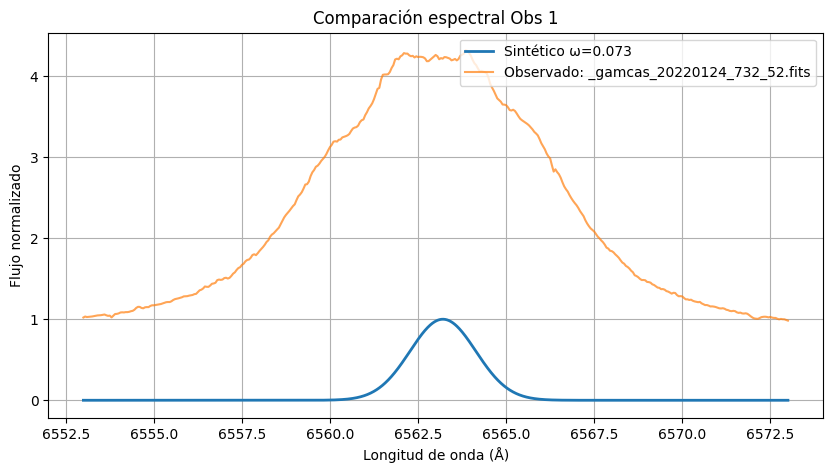

üü£ Comparando observaci√≥n 2 ‚Äî œâ = 0.073


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


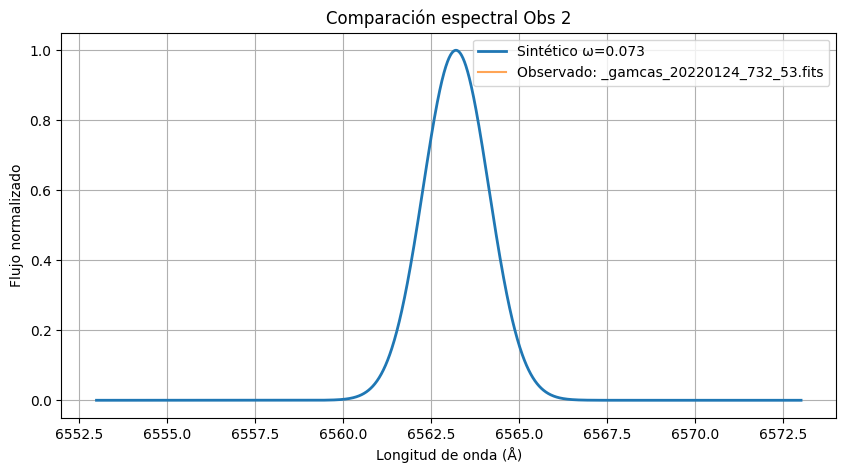

üü£ Comparando observaci√≥n 3 ‚Äî œâ = 0.185


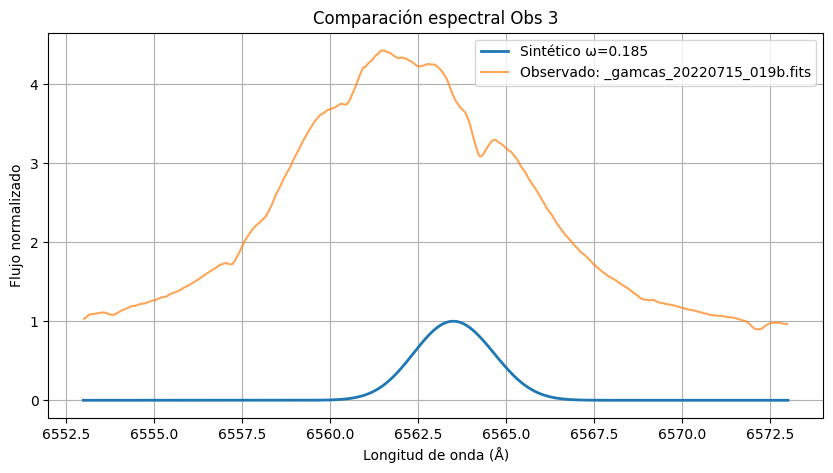

üü£ Comparando observaci√≥n 4 ‚Äî œâ = 0.176


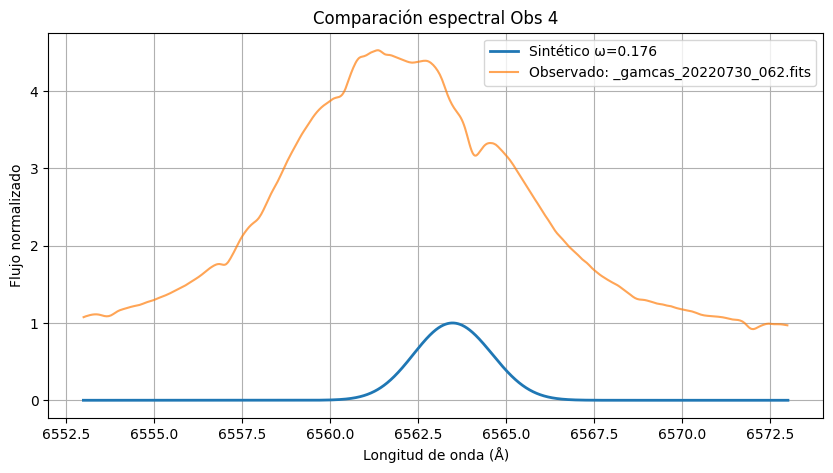

üü£ Comparando observaci√≥n 5 ‚Äî œâ = 0.051


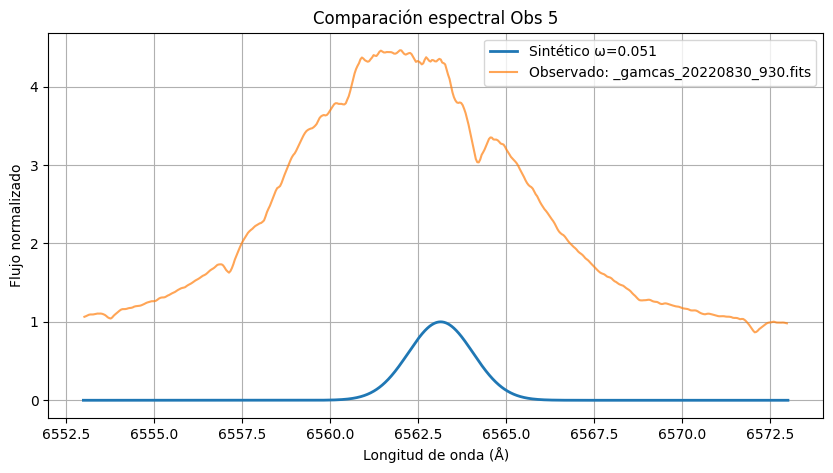

üü£ Comparando observaci√≥n 6 ‚Äî œâ = 0.045


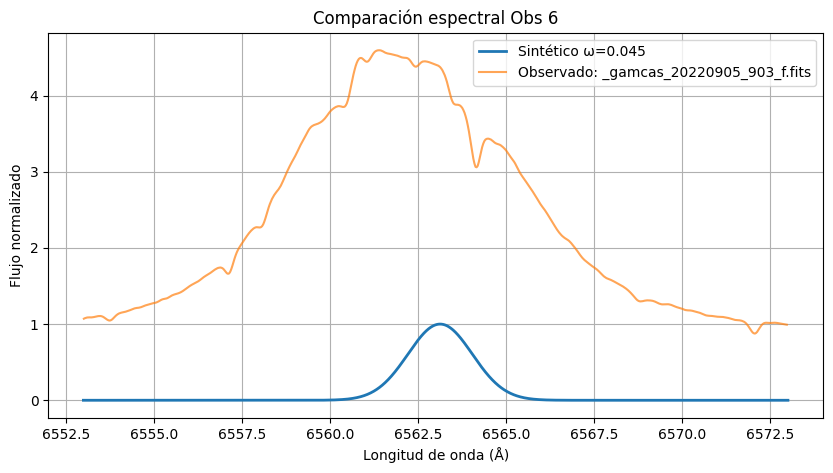

üü£ Comparando observaci√≥n 7 ‚Äî œâ = 0.178


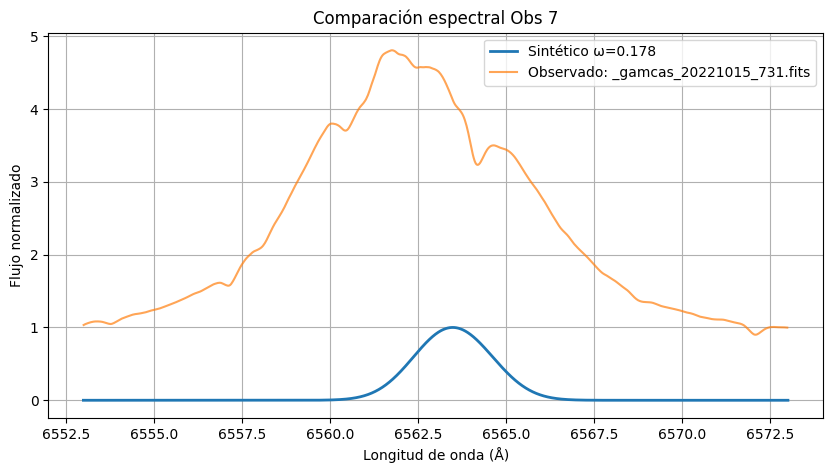

üü£ Comparando observaci√≥n 8 ‚Äî œâ = 0.177


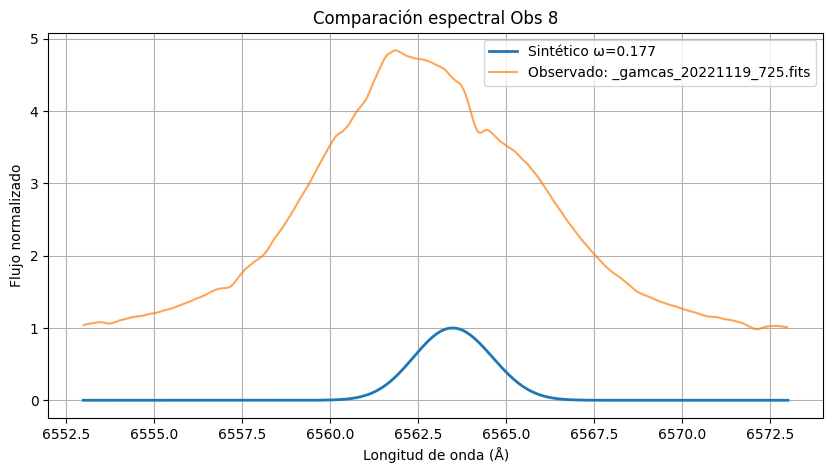

üü£ Comparando observaci√≥n 9 ‚Äî œâ = 0.180


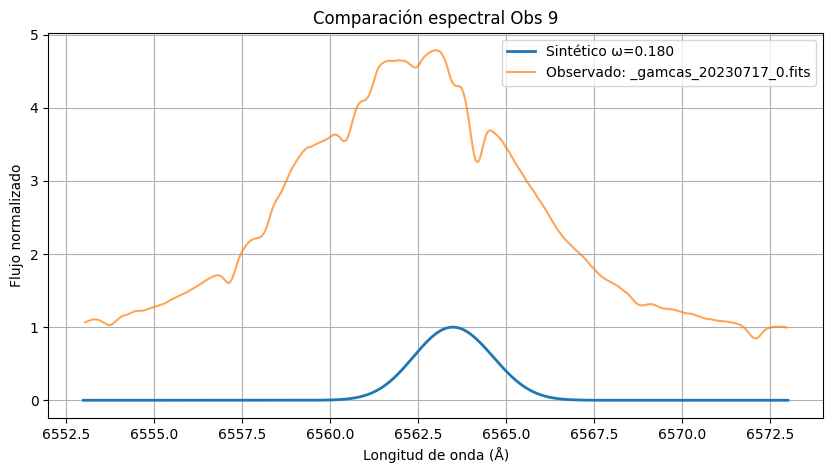

üü£ Comparando observaci√≥n 10 ‚Äî œâ = 0.179


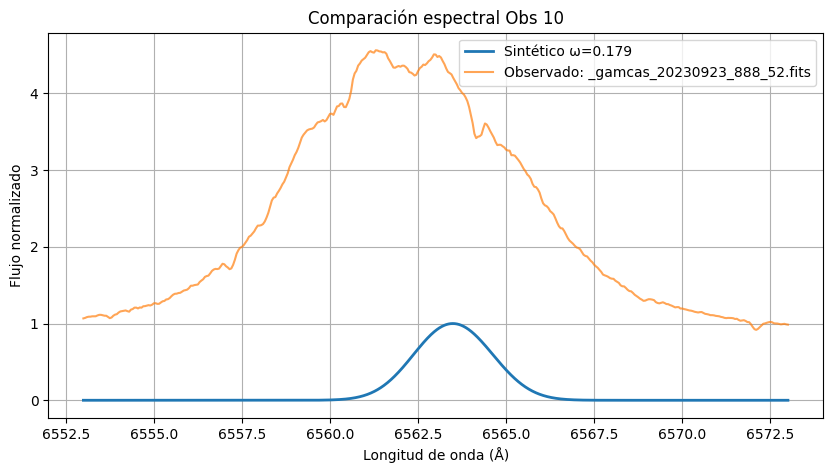

üü£ Comparando observaci√≥n 11 ‚Äî œâ = 0.073


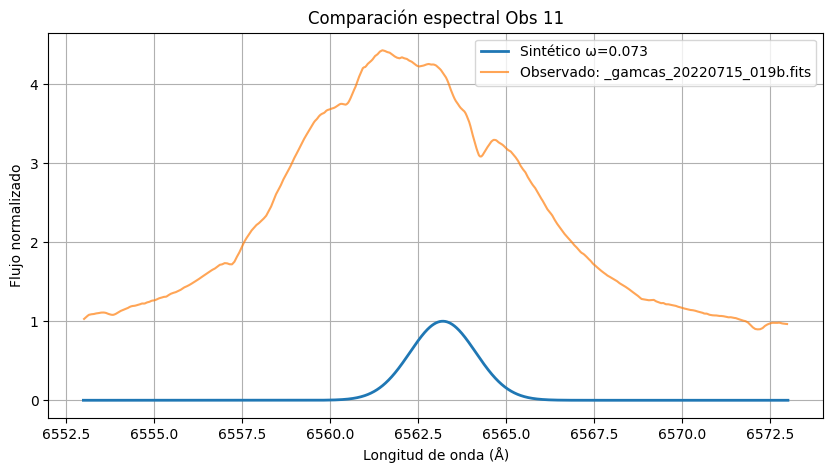

üü£ Comparando observaci√≥n 12 ‚Äî œâ = 0.184


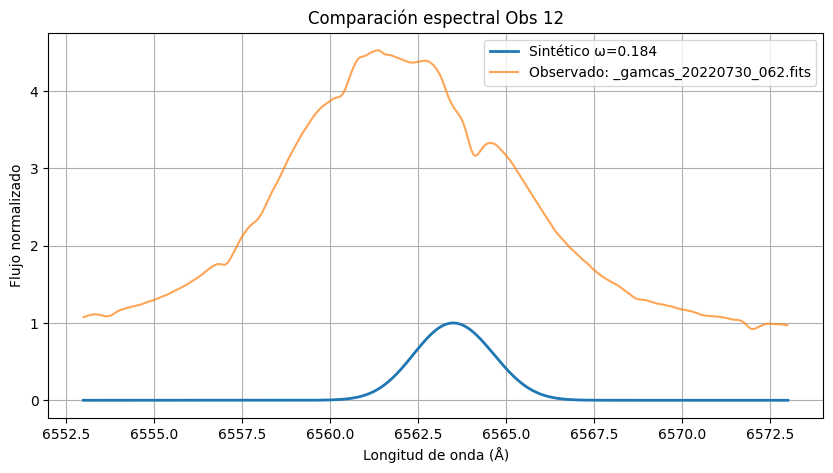

üü£ Comparando observaci√≥n 13 ‚Äî œâ = 0.073


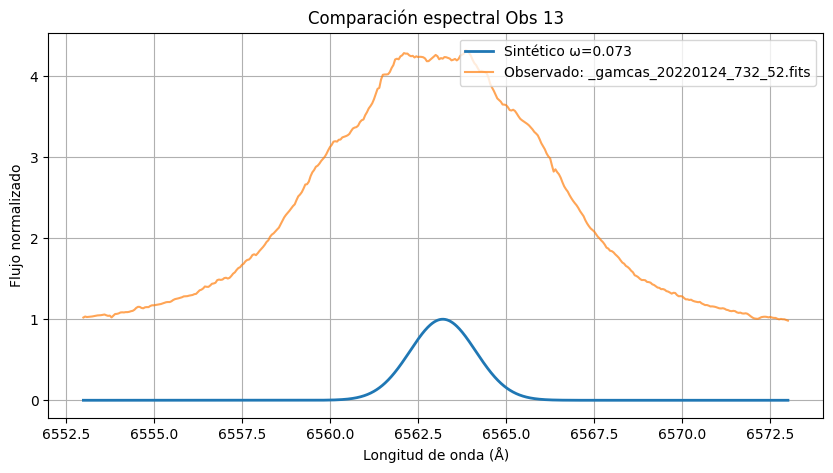

In [15]:
from astropy.io import fits

def cargar_espectro_fits(fits_path):
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        crval = header.get("CRVAL1", 0)
        cdelt = header.get("CDELT1", 1)
        num_pixels = len(data)
        wavelength_obs = crval + cdelt * np.arange(num_pixels)
    return wavelength_obs, data

def normalizar_y_recortar(wl_obs, flux_obs, lambda_0=6563, delta=10):
    mask_full = (wl_obs > lambda_0 - 20) & (wl_obs < lambda_0 + 20)
    continuum = np.median(flux_obs[mask_full])
    flux_norm = flux_obs / continuum
    mask_crop = (wl_obs >= lambda_0 - delta) & (wl_obs <= lambda_0 + delta)
    return wl_obs[mask_crop], flux_norm[mask_crop]

# --- Archivos .fits correspondientes ---
fits_files = [
    "_gamcas_20220124_732_52.fits",
    "_gamcas_20220124_732_53.fits",
    "_gamcas_20220715_019b.fits",
    "_gamcas_20220730_062.fits",
    "_gamcas_20220830_930.fits",
    "_gamcas_20220905_903_f.fits",
    "_gamcas_20221015_731.fits",
    "_gamcas_20221119_725.fits",
    "_gamcas_20230717_0.fits",
    "_gamcas_20230923_888_52.fits",
    "_gamcas_20220715_019b.fits",  # Repetidos por falta de m√°s archivos √∫nicos
    "_gamcas_20220730_062.fits",
    "_gamcas_20220124_732_52.fits"
]

# --- Comparar espectros sint√©ticos vs observados ---
for i, (fits_file, omega) in enumerate(zip(fits_files, omega_values)):
    print(f"üü£ Comparando observaci√≥n {i+1} ‚Äî œâ = {omega:.3f}")

    try:
        wl_obs, flux_obs = cargar_espectro_fits(fits_file)
        wl_crop, flux_crop = normalizar_y_recortar(wl_obs, flux_obs)

        espec_sint = espectros_sinteticos[i]

        plt.figure(figsize=(10, 5))
        plt.plot(wavelengths, espec_sint, label=f"Sint√©tico œâ={omega:.3f}", linewidth=2)
        plt.plot(wl_crop, flux_crop, label=f"Observado: {fits_file}", alpha=0.7)
        plt.xlabel("Longitud de onda (√Ö)")
        plt.ylabel("Flujo normalizado")
        plt.title(f"Comparaci√≥n espectral Obs {i+1}")
        plt.grid()
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"‚ö†Ô∏è Error con archivo {fits_file}: {e}")
